# Döberitzer Heide Nature Reserve K-Means Clustering for NDVI

We here introduce an object-oriented pipeline for searching, acquiring, and manipulating Sentinel-2 scene images and bands.  Our example below uses the [SatSearch API](https://medium.com/devseed/sat-api-an-api-for-spatiotemporal-asset-catalogs-88c3c78fdb0e) to query the _Earth on AWS_ datasets and compute the NDVI ([Normalized Difference Vegetation Index](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index)), as well as NDVI changes over time. We then computed the K-Means clusterirng centers both per image (greyscale levels) and over time (change analysis).

To acquire the images, we built our own download script, which uses the SatSearch query results, `boto3`, and `awscli` to acquire the images locally (See Issues below). We then computed the NDVI per set of Band4 (Red) and Band8 (NIR) images -- per time stamp per scene.  After this, we computed the K-Means clustering derived centers for both greyscale images (each NDVI separately) and for the temporal change analysis (pixel-by-pixel).  These independent metrics provide two glimpses into the spatial and temporal variations of biomass indicators over the AOI defined region surroudning the _Döberitzer Heide Nature Reserve_ near Berlin, DE.

<u>**K-Means**</u>  
K-Means clustering is a relatively well known unsupervised learning algorithm for determining the "sameness" of samples within a data set. It trains on these samples to identify the *K* centers of distributions or clusters (i.e. the 'means').  

The high-level overview of the K-Means algorithm (provided by [SciKit-Learn](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html)) is as such:  
1. Compute the squared distance between each sample and all *K* (initial guess at first) cluster centers
2. Label each data point by the nearest cluster center
3. Determine the relative distance between each cluster center and the average position across all samples per cluster
4. Update each cluster center to become the average center of its own cluster
5. Repeat Steps 1-4 until convergence or a predefined maximum number of iterations.

<u>**K-Means for Remote Sensing**</u>  
With remote sensing analysis, there are multiple methods to determine the cluster centers of an scene (of field of view):

1. If multiple bands exist over the same scene for the same time span (date-time), then the "colors per pixel" (band-to-band values) can be introduced as samples to determine the color-centers
2. If the image is grey scale, then the direct flux measurements can be used to infer a "center" for the grey scale; i.e. "black, dark grey, grey, light grey, white".
3. If multiple images of the same scene (greyscale or multibands) exist, then a temporal change analysis can be modeled using K-Means to determine the pixels over time that are most similar to each other
4. In all cases, added a meta data layer for the pixel coordinates (in lon/lat or x/y-inds) can be used to isolate regionally specific clusters; i.e. "roads in the south are different from roads in the north"

For further use overviews and examples, see also  
- [Analysis of Paddy Productivity Using NDVI and K-means
Clustering in Cibarusah Jaya, Bekasi Regency (Liyantono et al 2018)](https://iopscience.iop.org/article/10.1088/1757-899X/557/1/012085/pdf)  
- [Using new satellite imagery sources and machine learning to predict crop types in challenging geographies](https://medium.com/devseed/using-new-satellite-imagery-sources-and-machine-learning-to-predict-crop-types-in-challenging-4eb4c4437ffe)  
- [Sentinel-2 satellite imagery for crop classification: Part 2
](https://medium.com/devseed/sentinel-2-satellite-imagery-for-crop-classification-part-2-47db3745eb49)  
- [K-Means Algorithm to Recognize Grayscale
](https://medium.com/analytics-vidhya/k-means-algorithm-to-recognize-grayscale-6c9896e3c65f)  

<u>**NDVI (Normalized Difference Vegetation Index)**</u>  
NDVI is a widely used biomass indicator to determine the vegitation dominated areas of scenes. Because chlorophyll selectively absorbs Blue and Red wavelenghts, it has peaks in its solar reflectivity at Green and NIR wavelengths. In comparison, water, soil, roads, and other urban regions have a less significant solar reflectivity in the NIR. As such, a normalized difference (comparison) between the Red and NIR bands of Landsat, Sentinel, UAV, and other multi-spectral, remote sensing facilities provides an indicator value to determine the biomass metric per pixel or region (i.e. AOI). See Figure 11.4 in [Huete 2004](https://www.sciencedirect.com/topics/earth-and-planetary-sciences/spectral-reflectance).

Other biomass indicators exist, each with their own pros and cons. See [GeoPard Agriculture](https://geopard.tech/blog/tpost/kc9y2x96kv-which-vegetation-index-is-better-to-use) for an overview.

<u>**K-Means for NDVI**</u>  
The object oriented package that we developed here searches and loads the data from AWS Element84 Earth Search STAC API. [Earth Search](https://www.element84.com/earth-search/) is a "public search and discovery API for Earth on AWS datasets". It works with AWS to provide a [STAC](https://stacspec.org/) compliant API to search Sentinel-2 data products, stored on AWS. Earth Search provides a commmand line and Python API, called [Sat-Search](https://github.com/sat-utils/sat-search), to search the AWS database and download the data files to a cloud instance or local machine. 

For our example below, we detailed methods (2) and (3), above, by first measuring the NDVI for each scene and then temporally stacking these NDVI images into an _image cube_. We computed the K-Means clusters over the greyscale images; followed by computer the K-Means clusters with the stack of temporal pixels as input, to model similarities (_clusters_) between changes in pixels over time. 

<u>**Erratum**</u>  
**[Note]** The Sentinel-2 Earth AWS data are stored in a `request-pays` S3 bucket, which charges the user of Sat-Search; and thus this K-Means NDVI package. The user must have their `AWS_SECRET_ACCESS_KEY` and `AWS_ACCESS_KEY_ID` in their environment variables; as well as the `STAC_API_URL` set to `https://earth-search.aws.element84.com/v0`. Because we load the `.env` file during operations, these values can be stored and provided via a `.env` or other file using the `--env_filename` flag on the provided CLI (see below).

**[Note]** We provided a yml file to create a cond environment (`kmeans_ndvi_environment.yml`), which will provide all the necessary tools and packages to operate this notebook, and our related CLI interface.

`conda create --file kmeans_ndvi_environment.yml`

Moreover, the download api that we built for this project uses `boto3`, which interfaces with the `awscli` Python package. The user must therefore ensure that they have both installed and configured these packages.  
1. `conda install awscli boto3` -- included in the yml file  
2. `aws configure`  

**[Issue]** At the time of this writing, we were unable to use the `download` or `download_assets` methods of the satsearch api package. This situation seems to be recent and reproducible; [GitHub Issues](https://github.com/sat-utils/sat-search/issues/123) exist to address it. We provided a `simplified_tutorial_satsearch.py` example script that follows the [Sat-Search Tutorial](https://github.com/sat-utils/sat-search/blob/276a0551c0e119b5ff1ae0731bc2bd4f63335578/tutorial-1.ipynb), with the added `download_assets` operation to verify *if* the api is operational. The situation could be local to our AWS credentials; but not to our local system, because we confirmed that the error also exists when using an AWS EC2 instance.

**[Solution]** As oppose to waiting for the API to become operational -- or to address our possible AWS credientials situation -- we instead elected to construct our own AWS-S3 download api that uses the Sat-Search query operations and GeoDataFrame output to deliver the required JP2 (Sentinel-2 image files) to our local machine. 

---
**Load necessary system packages**

In [1]:
from dotenv import load_dotenv
from matplotlib import pyplot as plt

**Load local `kmeans_ndvi` package (developed here)**

In [2]:
from kmeans_ndvi import KMeansNDVI, KMeansNDVIParams, info_message

**Configure the input parameters for the SentinelAOI instance**  
In replacement of the `argparse.ArgumentParser` CLI Arguments (`clargs`) from the CLI provided, we introduced a `dataclass` call `KMeansNDVIParams` to play the role of user + IO input parameters

In [3]:
clargs = KMeansNDVIParams()
clargs.quiet = True
clargs.env_filename = '.env'

**Load local environment variables**  
To provide the necessary credentials to this Jupyter Notebook we stored them in a local `.env` file (not shared) and load it using the `dotenv.load_dotenv` package.

In [4]:
load_dotenv(clargs.env_filename);

**Create instance for the KMeansNDVI Class**  
To query, acquire, store, and process the Sentinel-2 Images, we provided `SentinelAOI` and `KMeansNDVI` classes, where `KMeansNDVI` inherits from the `SentinelAOI`.

Uncomment and run the `help(KMeansNDVI)` cell below for more information.

[Note] We default to `clargs.quiet = True` to avoid excessive `stdout` and visual output from the methods' runtimes.

In [5]:
# help(KMeansNDVI)

In [6]:
info_message("Generate JP2 KMeansNDVI Instance")
jp2_data = KMeansNDVI(
    geojson=clargs.geojson,
    start_date=clargs.start_date,
    end_date=clargs.end_date,
    cloud_cover=clargs.cloud_cover,
    collection=clargs.collection,
    band_names=[band_name_.upper() for band_name_ in clargs.band_names],
    download=clargs.download,
    n_clusters=clargs.n_clusters,
    n_sig=clargs.n_sig,
    quantile_range=clargs.quantile_range,
    verbose=clargs.verbose,
    verbose_plot=clargs.verbose_plot,
    quiet=clargs.quiet
)

INFO | utils.py:24 in info_message()
       message: 'Generate JP2 KMeansNDVI Instance'


**Confirm that the `jp2_data` instance is sound**  
Print the `__repr__` for the `jp2_data` instance to confirm that all settings are valid  

In [7]:
info_message(jp2_data)

INFO | utils.py:24 in info_message()
       message: SentinelAOI: 
                            AOI: doeberitzer_multipolygon.geojson
                     Start Date: 2020-01-01
                       End Date: 2020-02-01
                Cloud Cover Max: 1
                     Collection: sentinel-s2-l2a
                     Band Names: ['B04', 'B08']


**Download and Acquire Images**  
This method searches the Earth on AWS database using the `SatSearch` package, then downloads each file to our local harddrive (costs money) and stored the `filepaths` for each file in the `jp2_data` instance.

If the progress bar is desired, then set `jp2_data.quiet = False` here

In [8]:
info_message("Downloading and acquiring images")
# jp2_data.quiet = False
jp2_data.download_and_acquire_images()

INFO | utils.py:24 in info_message()
       message: 'Downloading and acquiring images'


**Load the JP2 files into memory**  
Here we loop over each `jp2_data.filepaths` entry and load the subsequent JP2 rasters, using rasterio, into the `jp2_data.scenes`  
data structure

In [9]:
info_message("Loading JP2 files into data structure")
jp2_data.load_data_into_struct()

INFO | utils.py:24 in info_message()
       message: 'Loading JP2 files into data structure'


**Loop and Compute the NDVI for all Scenes**  
Once all of the rasters are loaded and organized, we can (here) compute the NDVI for all scenes that include both a Band4 and Band8 rasters. Because it is possible that one of the these rasters is corrupted (locally or on the AWS database), we first confirm that both rasters were loaded correctly.

Moreover, if a user requests the download and acquire any band other than Band4 and Band8, then those rasters are stored in the `jp2_data.scenes` data structure; but will not be accessed while computing the NDVI images.

In [10]:
info_message("Computing NDVI for all scenes")
jp2_data.compute_ndvi_for_all()

INFO | utils.py:24 in info_message()
       message: 'Computing NDVI for all scenes'
/home/jonathan/anaconda3/envs/up42/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/mnt/d/Research/Jobs/Jobs2021/Up42/DataScienceChallenge/git_clone_test/kmeans_doeberitzer_heide_sentinel_up42/kmeans_ndvi/utils.py:236: RuntimeWarning: invalid value encountered in true_divide
  ndvi_masked = np.true_divide(


**Create the NDVI Temporal Image Cube**  
To later compute the K-Means Clusters per temporal pixel (over time), we must first stack the images into a data cube. This doubles the memory usages, and this therefore not a byproduct of computing the NDVI images first. This temporal image cube can be used for several temporally related machine learning or data analysis pipelines to be developed.

In [11]:
info_message("Allocating NDVI time series")
jp2_data.allocate_ndvi_timeseries()

INFO | utils.py:24 in info_message()
       message: 'Allocating NDVI time series'


**K-Means Clustering over Each NDVI Image**  
Loop over the set of NDVI images in the `jp2_data.scenes` data structure and compute the K-Means Clustering Centers with respect to the greyscale levels. We chose as a default `n_clusters=5`, which correspond to black, dark grey, grey, light grey, and white.

We chose as a default `n_clusters=5` because we were searching for 5 categories of objects: water, buildings, streets, soil, vegetation.  
Hyperparameter optimization (e.g. selecting the _best_ number of clusters) is our next step in this analysis. 

Because the results are often spatially connected in the reconstructed images (see below), our assumptions in using K-Means clustering are more likely to be valid than randomly picking an algorithm out of a hat. This is a positive sign for future development.

In [12]:
info_message("Computing spatial K-Means for each scene NDVI")
jp2_data.compute_spatial_kmeans()

INFO | utils.py:24 in info_message()
       message: 'Computing spatial K-Means for each scene NDVI'
WARNING | utils.py:29 in warning_message()
          message: 'NDVI cannot be computed without both Band04 and Band08'
WARNING | utils.py:29 in warning_message()
          message: 'NDVI cannot be computed without both Band04 and Band08'


**K-Means Clustering over the NDVI Time Series per Scene**  
Loop over the set of NDVI image cubes, per scene, in the `jp2_data.scenes` data structure and compute the K-Means Clustering Centers with respect to changes over time.  Because vegetation seeds, germinates, develops, whithers, and fades over time (seasonally with respect to weather patterns and climate), our assumption is that a temporal analysis will reveal similarities in pixels that include similar plants (trees, grass, etc); and dissimilarities between biomass rich pixels and urban development pixels (roads, buildings, etc). 

We chose as a default `n_clusters=5` because we were searching for 5 categories of objects: water, buildings, streets, soil, vegetation. Moreover, our greyscale analysis inferred that 5 was reasonable starting figure.  
Hyperparameter optimization (e.g. selecting the _best_ number of clusters) is our next step in this analysis. 

Because the results are often spatially connected in the reconstructed images (see below), our assumptions in using K-Means clustering temporally are likely to be more valid than randomly picking an algorithm out of a hat. This is a positive sign for future development.

In [13]:
info_message("Computing temporal K-Means for each scene NDVIs over time")
jp2_data.compute_temporal_kmeans()

INFO | utils.py:24 in info_message()
       message: 'Computing temporal K-Means for each scene NDVIs over time'


# Examine the Results

**Load the visual sanity check utilities**  
We developed three visual sanity checks to confirm that the data is sound and that the results are not random noise.  
1. The first of which shows the NDVI (per scene, resolution, date) and its related histogram. We excluded zero because it corresponds to the _outside_ the AOI.
2. The second visual sanity check reconstructs the image from the predicted spatial K-Means cluster centers to reveal the regional similarities.
3. The third visual sanity check reconstructs the image from the predicted temporal K-Means cluster centers to reveal the regional similarities.

In [14]:
from kmeans_ndvi.utils import (
    sanity_check_ndvi_statistics,
    sanity_check_spatial_kmeans,
    sanity_check_temporal_kmeans
)

**Examine the Statistics for a Single NDVI**  
Load a single NDVI parameters (scene, resolution, date) and plot its related histogram. We excluded zero because it corresponds to the _outside_ the AOI. As is expected of NDVI values, the values run from (slightly) below zero to (almost) one. NDVI values can span from -1 to 1; but this region is was selected because it is full of vegetation (i.e. _Nature Reserve_), which is reflected in the peak around 0.5.

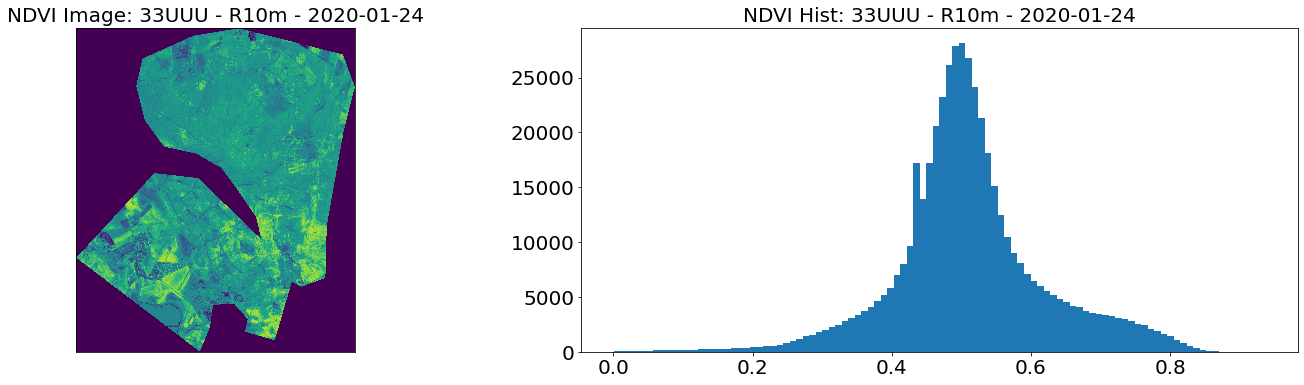

In [15]:
scene_id = '33UUU'
res = 'R10m'
date = '2020-01-24'
image = jp2_data.scenes[scene_id][res][date]['ndvi']
sanity_check_ndvi_statistics(image, scene_id, res, date, bins=100, plot_now=True)

**Examine the Clustering and Cluster Dependence for a Single NDVI**  
Reconstructs a single NDVI from the predicted spatial K-Means cluster centers to reveal the regional similarities. 
The visually connected behaviour of the K-Means cluster (spatial) labels coincides with our assumption that pixels of similar NDVI greyscale will be co-located, because they are likely to be similar in material (soil, streets, trees, water, etc).

We also examined here how each cluster is spatially located. And becuase the majority of structure is not random noise, we are more confident (compared to guessing) that K-Means is a reasonable algorithm to label vegetation rich areas using unsupervised learning.

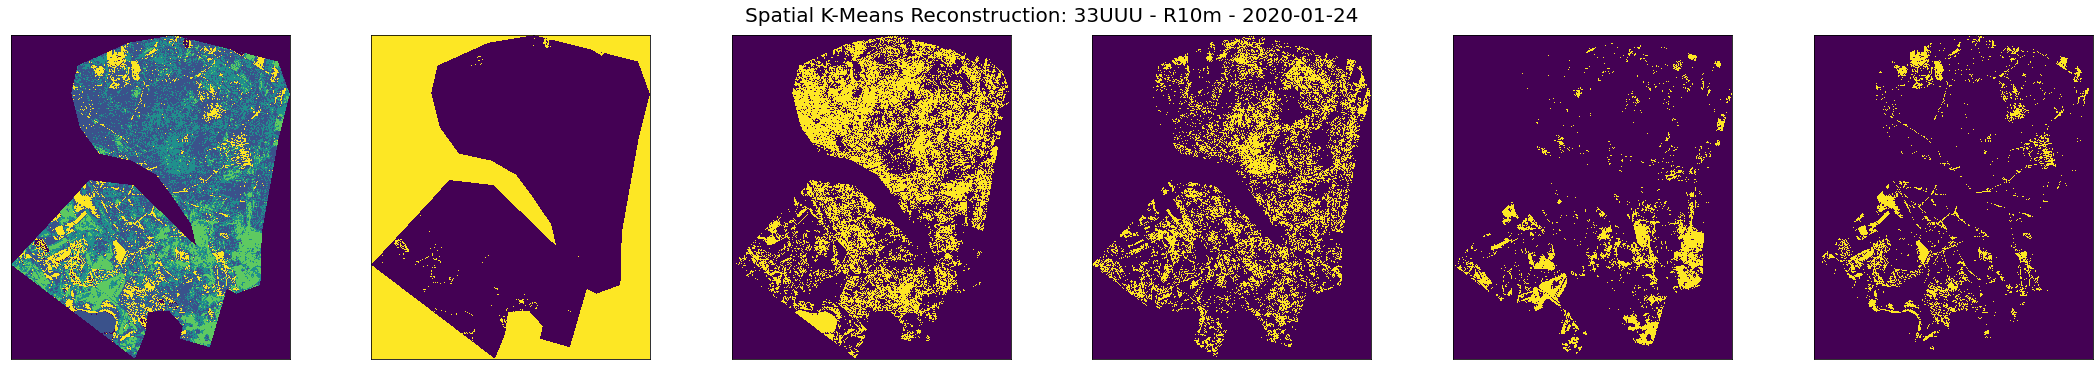

In [16]:
scene_id = '33UUU'
res = 'R10m'
date = '2020-01-24'
image = jp2_data.scenes[scene_id][res][date]['ndvi']
kmeans = jp2_data.scenes[scene_id][res][date]['kmeans'][jp2_data.n_clusters]
sanity_check_spatial_kmeans(
    kmeans,
    image,
    jp2_data.quantile_range,
    scene_id,
    res,
    date,
    plot_now=True
)

**Examine the Clustering and Cluster Dependence for a Temporal Image Cube**  
Reconstructs a single image from the predicted temporal K-Means cluster centers over the pixel-by-pixel analysis from our NDVI image cube to reveal the regional similarities in their temporal change behaviour. 
The visually connected behaviour of the K-Means cluster (spatial) labels coincides with our assumption that pixels of similar NDVI values over time will be co-located, because they are likely to be similar in material (soil, streets, trees, water, etc); i.e. streets will not vary in NDVI over time the same way as trees; but grass and trees may vary over time similarly.

We also examined here how each temporal cluster is spatially located. And becuase the majority of structure is not random noise, we are more confident (compared to guessing) that K-Means is a reasonable algorithm to label vegetation rich areas using unsupervised learning.

We do note here that the reconstructed image from the temporal K-Means clustering shows more dispersed results (less rigidly connected) than the single NDVI K-Means clustering. This could because we were lucky in visualizing the specific scene, resolution, date scene above; thus the temporal NDVI image cube includes more information, including more variance.

It will be a worthwhile consideration to either
- Combine the spatial and temporal information into a single K-Means analysis [Example: spatially blending pixels before ]
- Examine the spatial NDVI cluster reconstruction regions over time (not from the temporal K-Means analysis) to compare the regionally similarities (or divergencies) in cluster predictions.

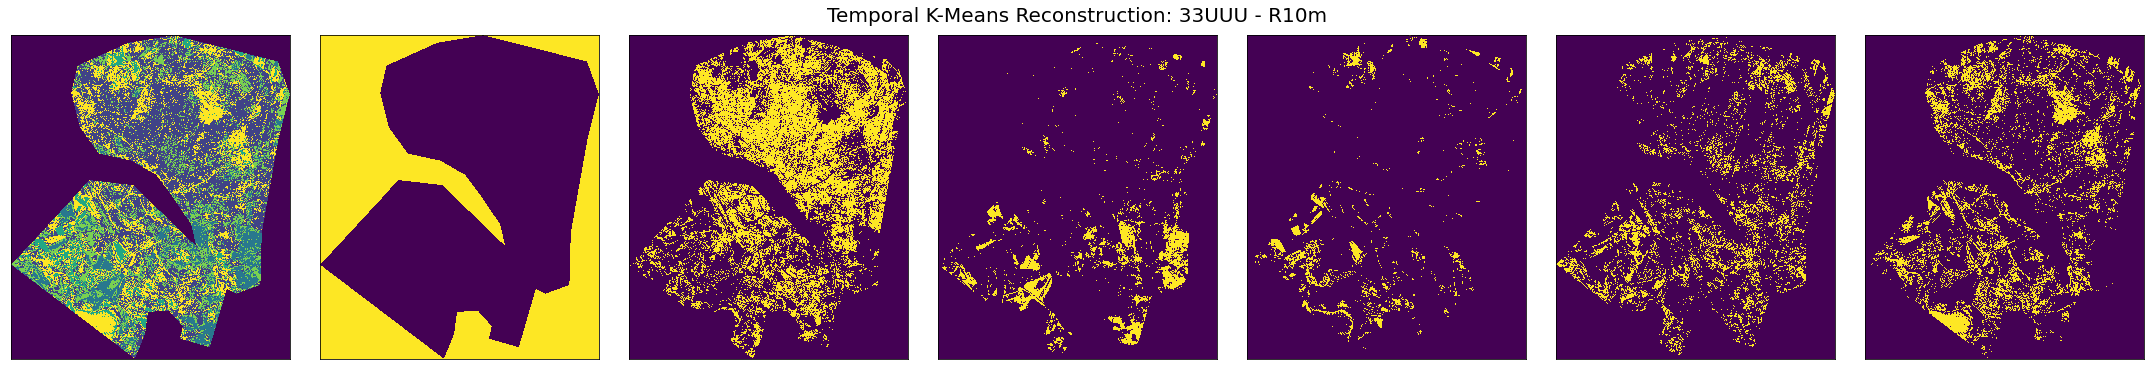

In [17]:
scene_id = '33UUU'
res = 'R10m'
date = '2020-01-24'
image_stack = jp2_data.scenes[scene_id][res]['timeseries']['ndvi']
kmeans = jp2_data.scenes[scene_id][res]['timeseries']['kmeans'][jp2_data.n_clusters]
sanity_check_temporal_kmeans(
    kmeans,
    image_stack,
    quantile_range=jp2_data.quantile_range,
    scene_id=scene_id,
    res=res,
    plot_now=True
)